# Puzzle piece detection, segmentation and shape clusterization
Student: Luan Vinícius de Carvalho Martins

#### Abstract
This project employs edge-detection, morphological operators, and image measurements for puzzle pieces segmentation and counting while also attempting to cluster the different shapes together. Following advice from the partial report's results, image enhancement techniques were used to improve the detection. Results show that the method can generate acceptable results in controlled environments. In particular, the usage of image enhancement methods significantly improved the outcomes and robustness of the technique.


### Introduction

In this project, we aim to identify, count, and cluster puzzle pieces with similar shapes. This task can be useful as a common technique to solving large piece puzzles is to [group pieces with similar features together](https://ceaco.com/blogs/news/tips-tricks-completing-1000-piece-puzzle). 

One of the main challenges stems from the fact that the final project had to be proposed before most classes were presented, therefore, it provided a great context to search and learn new methods for image analysis. By analyzing the task at hand, we decided to investigate image segmentation using edge-detection, as, indeed, our goal is to identify the edges that form the pieces in a given image.

Once the edges are detected, another task is to extract them in a meaningful representation so that they could be further used and analyzed. For this task, we proposed and employed a simple search algorithm that takes as input a reference pixel and outputs a list of pixels that are connected to it (using its 4-pixel neighborhood). Finally, in order to cluster similar shapes together, we needed a way to calculate and measure similarity the piece's shape in a scale, rotation, and transform invariant fashion; for this task, we employ a set of measures named `Hu Moments` that could be used to generate array representation of the pieces.

Following advice from the partial report's results, we also implemented the options to apply image transformation functions (e.g., enhance contrast, change brightness, gamma correction) in order to create variations of the input image that are combined in hopes of improving the detection results. Our results shows that the usage and combination of image enhancement methods can produce can significantly improve results. 

In the next section, we quickly describe some of the methods we used why they were chosen. Section 3 presents a `Python` implementation of the proposed method, using techniques from the `skimage` library. Next, in Section 4, we show some results based on the testing images; Finally, we conclude this report.


### Methodology

In this section, we describe some of the techniques used and explain the reasoning behind choosing them.

#### Canny edge detection
The Canny edge detection technique is based on a clever idea that edges usually represent drastic changes in the pixel color, therefore, they are the first to be removed when blurring out an image. This technique works by blurring an image using a gaussian blur with a given sigma and calculating the rate of change for each pixel in comparison to the original image: if the rate of change is inside a given threshold, the pixel is considered to be an edge. 

We have chosen this technique because it provided the best results, returning hollow and mostly pixel-connected pieces' edges. Notice that we have previously attempted other methods for edge detection, some of them implemented by scratch, including an approach that combines different techniques; however, we were unable to obtain results as good as the ones provided by the canny edge detection.

#### Morphology techniques
Unfortunately, the edge detection techniques will frequently fail to detect all edges, returning incomplete shapes that cannot be used. To solve this, morphology techniques are commonly used to improve the detected edges, either by making the edges wider or by attempting to fill gaps between disconnected pixels. For this task, two morphology techniques proved to be helpful:
 - Dilation: increases the width and size of the detected edges, which increses the chance of connected disconnected edges;
 - Closing: helps closing edges that almost connected;
 - Erosion: once we have increase the edge's width in order to connect disconnected pixels, we apply erosion in order to repair some of the shape.

#### Hu Moments
Hu Moments is a set of measurements commonly used to characterize shape and calculate shape similarity. This technique has proven to be translate, scale, and rotation invariant (up to the 6th moment). Therefore it should provide an equal image representation regardless of whether it has been rotated or rescaled. The few limitations of this technique are that input images must be a binary image -- it can only be used to compare shapes.


### Method
In this section, we go into the Python implementation details of the model.

#### Libraries

In this project, we employ techniques from the `skimage` library for image transformation, morphology, and measurements. We also use the `scipy` library for clustering, `matplotlib` for drawing, and `imageio` to load images into `numpy` arrays. 

We decided to use `skimage` techniques for the report in order to save time, allow to easily prototype the model and to check the viability of the project. Our previous attempts used techniques implemented from scratch; however, this proved a challenge as there was no certainty that the method would generate good results or even be employed in the final version. 

In [1]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.ndimage import binary_fill_holes
from skimage.measure import moments_hu, moments_normalized, moments_central
from skimage.morphology import dilation, erosion, closing, disk
from skimage.feature import canny
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import imageio

#### Preprocessing

The preprocessing phase merely converts an RGB image to a black and white one using the luminance technique. Another proper preprocessing technique is to downsample the image into a smaller size to save computational resources. However, as the images we are using on the partial report have already been converted into an acceptable resolution, we will skip this function.

Additionally, many image analysis models can produce more robust and stable results by applying image enhancement methods. Simple methods such as changing the brightness, contrast and applying gamma correction can be used to create variations of the input image that can be combined in the analysis. In order to implement a few image enhancement methods, we have included in our proposal the option to apply image transformation functions that produce variations of the input images that are combined by the edge detection technique. In particular, we found that balancing the contrast using the histogram and the variations produced by gamma correction methods increased the quality of the results. 

In [75]:
def greyscale(img: np.array) -> np.array:
    """
    Convert image to black and white using the luminance method.

    :param img: input image
    :return: black and white version of the image
    """
    return np.dot(img[..., :3], [0.2989, 0.5870, 0.1140])
    
def histogram_equalisation(img: np.array) -> np.array:
    """
    Enhance the image by applying a common contrast enhancement technique using the cumulative histogram of the
    input image.

    :param img: the input image
    :return: the transformed image with enhanced contrast
    """
    cumulative_histogram = {value: np.sum(img <= value) for value in range(256)}
    improve_contrast = np.vectorize(lambda v: (255 / np.multiply(*img.shape)) * cumulative_histogram[int(v)])
    return improve_contrast(img)

def gamma_correction(img: np.array, y: float):
    """
    Enhance the image by applying a gamma correction method. Used to create variations of the input picture
    that could improve the edge highlight results (though edge detection).

    :param img: the input np.array image
    :param y: the y parameter for the gamma correction
    :return: the transformed np.array image
    """
    return np.vectorize(lambda v: 255.0 * (v / 255.0) ** (1 / y))(img)

def invert(img: np.array):
    return 255 - img

def contrast(img: np.array, new_range: list):
    return (img - img.min()) * ((new_range[1]-new_range[0]) / (img.max() - img.min())) + new_range[0]

#### Image Transform for Piece Identification

The first step is to transform the input image to highlight the possible pieces for extraction. As explained in a previous section, we concluded that an edge-detection technique would be appropriate for the task, and after testing several techniques we found that the Canny Edge-Detection technique was the most appropriate to the task due to its false-positive edge filtering phase.

Furthermore, in other to improve the highlighting, we employ morphology techniques such as `dilation` and `closing` in hopes of filling gaps in places the edges were not detected. After the partial report, we also employed the `erosion` operation in order to improve regions in which there should be gaps, creating a more representative shape of the piece. Finally, the last step is to fill the closed edges to highlight whole pieces.

The transformed image is then returned, and the pieces can be extracted.

To increase the robustness of the method, the user may also choose to employ image enhancement techniques. The provided enhancement techniques are used to create variations of the input image for the edge detection phase, which are combined in hopes that edges that were missed by one variation of the input may be detected in another. To combine the different variations robustly, we only consider a pixel to belong to a border if detected in two or more images. The usage of image enhancement techniques showed to produce false positives that should be filtered out. 

In [58]:
def canny_with_enhancement(img: np.array, sigma: float, lt: float, ht: float, enhance):
    return canny(enhance(img) if enhance is not None else img,
        sigma=sigma,
        low_threshold=lt,
        high_threshold=ht,
        use_quantiles=True)


def highlight_pieces(img: np.array, sigma: float = 3, lt=.3, ht=.7, enhancements=None) -> np.array:
    """
    Transform the input image to highlight the possible pieces using edge-detection and morphology techniques.

    :param img: the input image to be transformed
    :param sigma: the sigma parameter for the canny edge-detection technique
    :param lt: lower threshold for the edge-detection technique
    :param ht: higher threshold for the edge-detection technique
    :param enhancements: list of enhancement methods to create variations of the input image
    :return: a transformed image which hopefully highlights the puzzle's pieces
    """
    # first we apply the Canny edge detection technique to highlight edges
    if enhancements is None:
        # no enhancement techniques employed, run edge detection to highlight edges
        img_edges = canny(img,
            sigma=sigma,
            low_threshold=lt,
            high_threshold=ht,
            use_quantiles=True)
    else: 
        # enhancement functions were requested, request the canny method on an enhanced version of the image
        imgs_edges = Parallel(n_jobs=len(enhancements))\
            (delayed(canny_with_enhancement)(img, sigma, lt, ht, enhance) for enhance in enhancements)
        img_edges=np.zeros(img.shape)
        for img in imgs_edges:
            img_edges += img
        img_edges = img_edges >= 2
    
    default_disk = disk(2)
    # then, we apply dilation to enhance the detected edges by increasing its width and size, hopefully filling
    # missing gaps on the original result
    img_edges_dilated = dilation(img_edges, default_disk)
    img_edges_dilated_closing = closing(img_edges_dilated, default_disk)
    img_edges_filled = binary_fill_holes(img_edges_dilated_closing)
    # finally, we will fill all the spaces inside connected edges
    return erosion(erosion(img_edges_filled,  disk(1)))

#### Piece segmentation

Once the input image has been transforming to highlight the possible pieces, we should have a black and white image where the white pixels represent the pixels that belong to a piece. The next step on the piece segmentation is to define rules to extract these pixels into meaningful piece information.

The technique itself is divided into two parts (part 1 is `extract_pieces` and part 2 is `extract_piece`)
In part 1, we will create a list containing all white pixels on the image, and for each pixel, we will search all connected pixels. 
Part 2 is a simple search algorithm that explores all connected pixels to the reference one: it will explore the image until all pixels connected to the reference are found. 
Once a _possible_ piece is extracted, the white pixels that belong to this piece are removed from the search, which continues until there are no more white pixels in the image to explore.

Once all white pixels are extracted, we have a list of _possible_ pieces, which must be filtered to remove pixels that are unlikely to represent a puzzle piece. So far, we employ two criteria to filter out unlikely pieces: 
 - we set a minimum pixel count threshold to remove sets of connected pixels that are too small to represent a piece; 
 - we remove pieces that are not "square" enough, i.e., its height is double its width.

In [36]:

def extract_piece(img: np.array, location: tuple):
    """
    Extract the connected pixels to the the provided location using a basic search algorithm.
    Part II of the extraction process which focus on returning the set of connected pixels from a
    reference one.

    :param img: the transformed image
    :param location: the pixel location
    :return: a set of pixels connected to the current one
    """
    to_visit = set([location])
    visited = set()

    # simple search algorithm to find all connected pixels
    while len(to_visit) > 0:
        current = to_visit.pop()
        if current[0] - 1 > 0 and img[current[0] - 1, current[1]]:
            pos = tuple([current[0] - 1, current[1]])
            if pos not in visited: to_visit.add(pos)
        if current[0] + 1 < img.shape[0] and img[current[0] + 1, current[1]]:
            pos = tuple([current[0] + 1, current[1]])
            if pos not in visited: to_visit.add(pos)
        if current[1] - 1 > 0 and img[current[0], current[1] - 1] > 0:
            pos = tuple([current[0], current[1] - 1])
            if pos not in visited: to_visit.add(pos)
        if current[1] + 1 < img.shape[1] and img[current[0], current[1] + 1]:
            pos = tuple([current[0], current[1] + 1])
            if pos not in visited: to_visit.add(pos)
        visited.add(current)
    return visited


def extract_pieces(img: np.array, min_pixels_threshold=5000) -> list:
    """
    Extract the pieces from the transformed input image

    :param img: the transformed image with the pieces highlighted
    :param min_pixels_threshold: the minimium amount of pixels to consider a piece
    :return: a list of detected pieces
    """
    pieces = []
    # location in which there are activated pixels:
    locations = np.asarray(np.where(img == True)).transpose()
    available = set([tuple(location) for location in locations[:]])
    while len(available) > 0:
        # take a reference pixel and extract its connected pixels
        current = available.pop()
        piece = extract_piece(img, tuple(current))
        # remove the pixels connected from the reference one from the list:
        available.difference_update(piece)
        # add the pixel to the list of possible pieces if it matches the criteria
        if len(piece) > min_pixels_threshold:
            pieces.append(piece)
    return pieces


def piece_to_img(piece: list) -> np.array:
    """
    Given a set of pixels that belong to a piece, convert it to a square image matrix. This
    is used to display and calculate measurements from shape detected.

    :param piece: a list of tuple containing the pixels of the piece
    :return: a np.array image of the piece
    """
    x = [p[0] for p in piece]
    y = [p[1] for p in piece]
    # the shift and height of the piece's shape to generate a new image
    shift_x = min(x)
    height_x = max(x) - shift_x
    shift_y = min(y)
    width_y = max(y) - shift_y
    # start a new image with zeros
    n_img = np.zeros((height_x + 1, width_y + 1))
    for px in piece:
        # paint each pixel with one to generate the shape
        n_img[px[0] - shift_x, px[1] - shift_y] = 1
    return n_img

#### Piece Shape Clustering

Once we have extracted the pieces from the input image, we can attempt to cluster pieces with similar shapes together. For this task, we employ the `hu moments` technique from the `skimage` library on the image representation of each piece. Using this measure, we generate an `np.array` that describes each shape as an array which can be used calculate the similarity between puzzle pieces in an scale, translate and rotation invariant way.

In [105]:
def pieces_embedding(pieces: list) -> np.array:
    """
    Generates an np.array dataset representation of the detected pieces using the Hu Moments measurement.
    This representation can be used to cluster similar shapes together.

    :param pieces: a list containing the set of pixels for each piece
    :return: np.array dataset representation of the Hu Moments
    """
    # use the Hu Moments to generate an array represe
    embeddings = np.asarray([moments_hu(moments_normalized(moments_central(piece))) for piece in pieces])
    return embeddings / embeddings.sum(axis=1)[:, np.newaxis]

#### Img2Piece

The proposed method can be implemented into an easy-to-use function using the following algorithm. As outputs, the function returns two lists: the first contains a set of pixels representing each piece in the image. The second list contains `np.array` images of the detected pieces, which describe their shape.

Notice that optionally the user may also employ a set of `enhancements` functions that will be applied to the image.

In [26]:
def img2piece(img: np.array, shape_radius=0.5, enhancements: list=None) -> (list, list):
    """
    Extract the pieces from the input image. Return the piece pixel's indices and
    images from the pieces.

    :param img: input RGB image
    :param shape_radius: the radius to filter out image
    :param enhancements: enhancement techniques to improve the image
    :return: (list, list), pixels and image
    """
    # cast image to grey scale
    img_g = greyscale(img)
    # run edge-detection and morphology techniques to highlight possible pieces
    img_h = highlight_pieces(img_g, 3, .9, .95, enhancements)
    # extract the pieces from the highlighted pixels
    possible_pieces = extract_pieces(img_h)
    # transform the pixels into images of their own
    possible_img_pieces = [piece_to_img(piece) for piece in possible_pieces]
    # filter out the possible pieces using the second criteria
    pieces, imgs = [], []
    for id, piece in enumerate(possible_img_pieces):
        # checking the second criteria (shape -- has to look somewhat like a square):
        if np.abs(1 - (piece.shape[1] / piece.shape[0])) < shape_radius:
            pieces.append(possible_pieces[id])
            imgs.append(piece)
    # return a list containing for each piece, its pixels and its image
    return pieces, imgs

### Proposed method results

In this section, we employ the proposed technique to a set of images in order to see how it performs for detection and counting, shape identification and, finally, clustering.

In [85]:
# the images we are going to be using to test the method
test_images = [
    "one-piece-detection.jpg",
    "two-pieces-detection.jpg",
    "three-pieces-detection.jpg",
    "four-piece-detection-.jpg",
    "four-piece-detection-2.jpg",
    "many-pieces-detection.jpg"
]

# list of enhancements function to hopefully improve the piece detection:
enhancement_options = [
    None, # use the original image as well
    histogram_equalisation, # histogram equalisation
    invert,
    lambda img: contrast(img, [100, 110]),
    # just creating variations of the input image using gamma correction:
    lambda img: gamma_correction(img, 0.2), # gamma correction with y = 0.2 
    lambda img: gamma_correction(img, 0.5), # gamma correction with y = 0.5 
    lambda img: gamma_correction(img, 0.9), # gamma correction with y = 0.9
    lambda img: gamma_correction(img, 1.1), # gamma correction with y = 1.1
    lambda img: gamma_correction(img, 1.4), # gamma correction with y = 1.4
    lambda img: gamma_correction(img, 2), # gamma correction with y = 2
]

#### Piece Detection and Counting

One of the main goals of this project is to detect and count the puzzle pieces in a given image. In this section, we show how the method performs on different images for detection and counting.

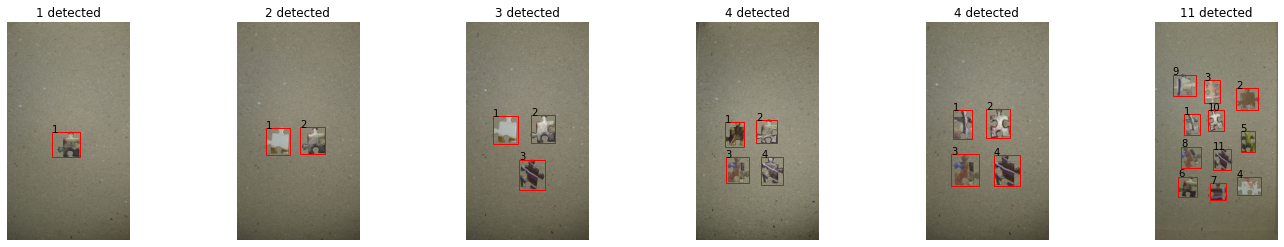

In [41]:
def piece_counting_detection(files: list):
    fig, axs = plt.subplots(1, len(files), figsize=(4*len(files), 4))
    for idx, file in enumerate(files):
        img = imageio.imread(file)
        pieces_px, pieces_img = img2piece(img, enhancements=enhancement_options)
        ax = axs[idx] if len(files) > 1 else axs
        ax.imshow(img)
        ax.set_title(str(len(pieces_px))+" detected")
        ax.axis('off')
        for pxs_idx, pxs in enumerate(pieces_px):
            xs = [px[1] for px in pxs]
            ys = [px[0] for px in pxs]
            x1 = np.min(xs)
            y1 = np.min(ys)
            x2 = np.max(xs) - x1
            y2 = np.max(ys) - y1
            rect = patches.Rectangle((x1, y1), x2, y2, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1, str(pxs_idx+1))
    plt.show()
piece_counting_detection(test_images)

#### Piece segmentation quality

In order to cluster the similar shapes together, it's essential that the shape detected is representative of the actual shape of the piece. In this section, we evaluate the quality of the shape detected from the image by printing what the method obtained. 

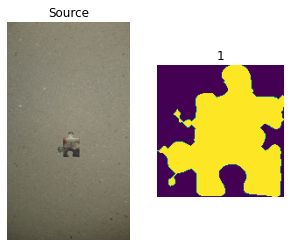

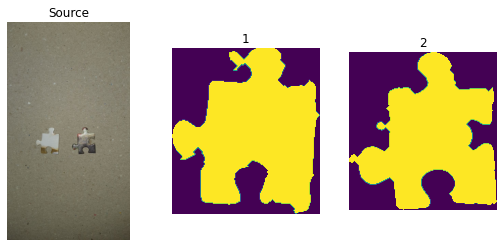

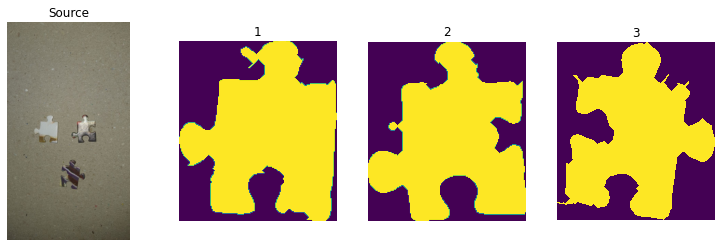

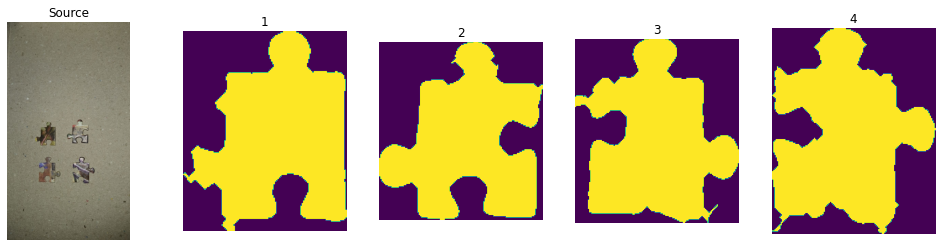

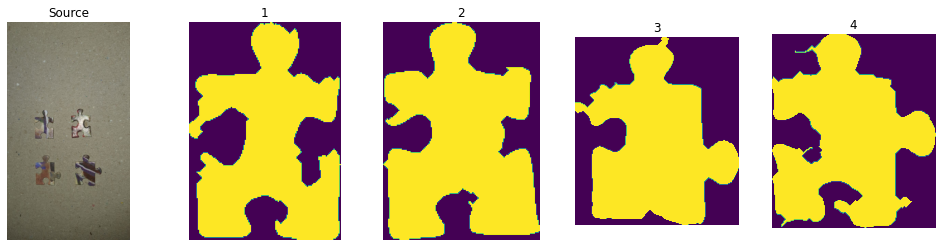

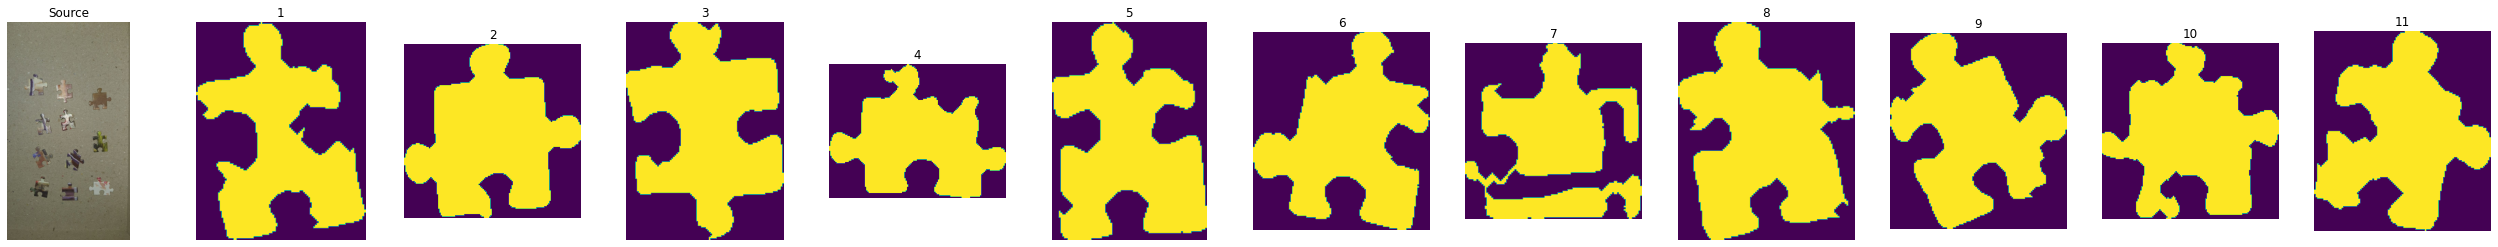

In [86]:
def piece_segmentation(files: list):
    for file in files:
        img = imageio.imread(file)
        pieces_pxs, pieces_img = img2piece(img, enhancements=enhancement_options)
        fig, axs = plt.subplots(1, len(pieces_img)+1, figsize=(4*len(pieces_img)+1, 4))
        ax = axs[0]
        ax.set_title("Source")
        ax.imshow(img)
        ax.axis("off")
        plt.title(file)
        for pxs_idx, pxs in enumerate(pieces_img):
            ax = axs[pxs_idx+1]
            ax.axis('off')
            ax.imshow(pxs)
            ax.set_title(str(pxs_idx+1))
        plt.show()

piece_segmentation(test_images)

#### Piece shape clustering

Finally, we verify how the method performs in terms of shape clustering. For this, we create an array representation of the image using Hu Moments and cluster it using a hierarchical clustering technique. The results are presented in a dendrogram with the original image and the detected shapes with its' id.

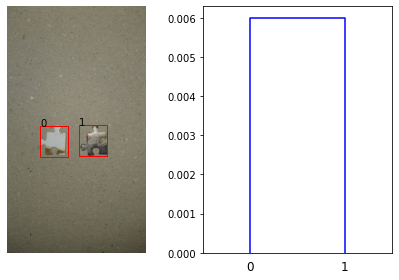

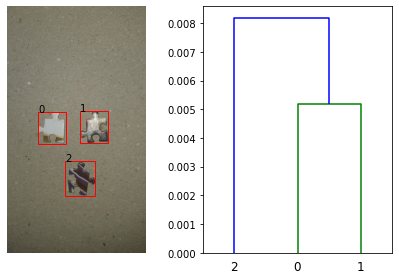

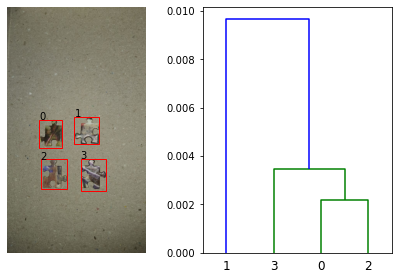

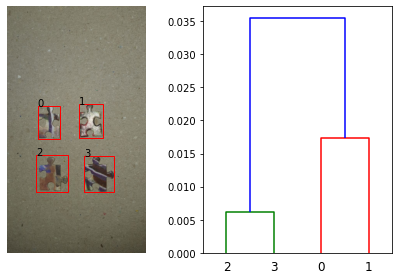

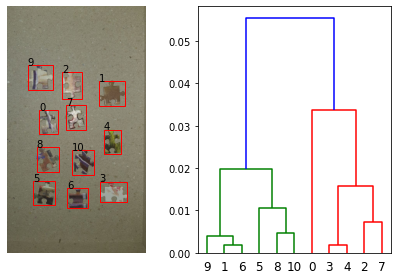

In [106]:
def piece_shape_clustering(files: list):
    for file in files:
        img = imageio.imread(file)
        pieces_px, pieces_img = img2piece(img, enhancements=enhancement_options)
        if len(pieces_px) > 1:
            embeddings = pieces_embedding(pieces_img)
            fig, axs = plt.subplots(1, 2)
            axs[0].imshow(img)
            axs[0].axis('off')
            for pxs_idx, pxs in enumerate(pieces_px):
                xs = [px[1] for px in pxs]
                ys = [px[0] for px in pxs]
                x1 = np.min(xs)
                y1 = np.min(ys)
                x2 = np.max(xs) - x1
                y2 = np.max(ys) - y1
                rect = patches.Rectangle((x1, y1), x2, y2, linewidth=1, edgecolor='r', facecolor='none')
                axs[0].add_patch(rect)
                axs[0].text(x1, y1, str(pxs_idx))
            Z = linkage(embeddings, method='complete')
            dendrogram(Z, ax=axs[len(axs)-1])
            plt.tight_layout()
            plt.show()

piece_shape_clustering(test_images)

#### Enhancement improvements

We also compare the impact of using or not the enhancement functions on the input image. Notice that we have fixed simple image enhancement algorithms and the results could be even improved with a new selection. 

The results shows that the variations produced by the enhancement functions are benefitial for the correct detection of the puzzle pieces. However, it should be noted that they may also create artfacts: for instance, the contrast adjustment method changes the patterns on the background enough to be detected by the edge detection method as well. 

Additionally, it should be noted that the due to improvements in the applyed morphological techniques also increased the quality of the detection. The results from the final version are significantly improved from the [partial report](https://github.com/luanvcmartins/proc-img-final-project/blob/main/partial-report/preliminary-results.ipynb), with all the pieces correctly filled.

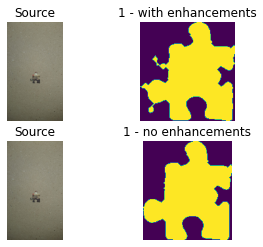

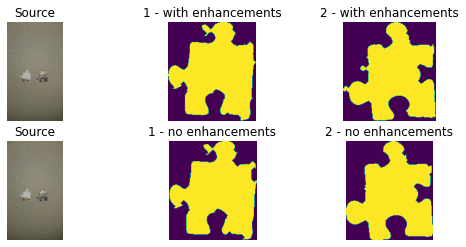

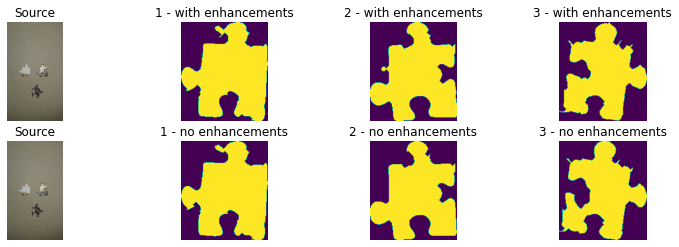

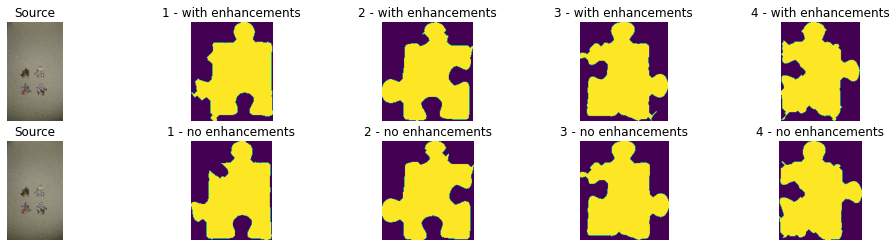

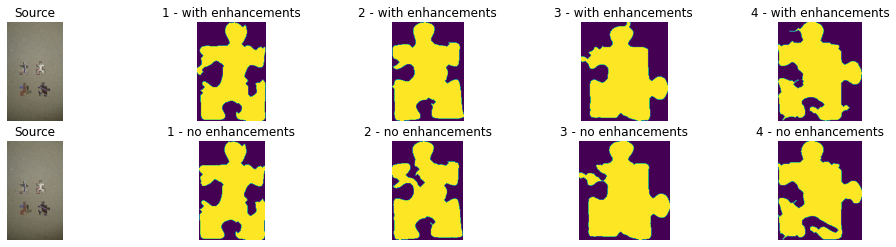

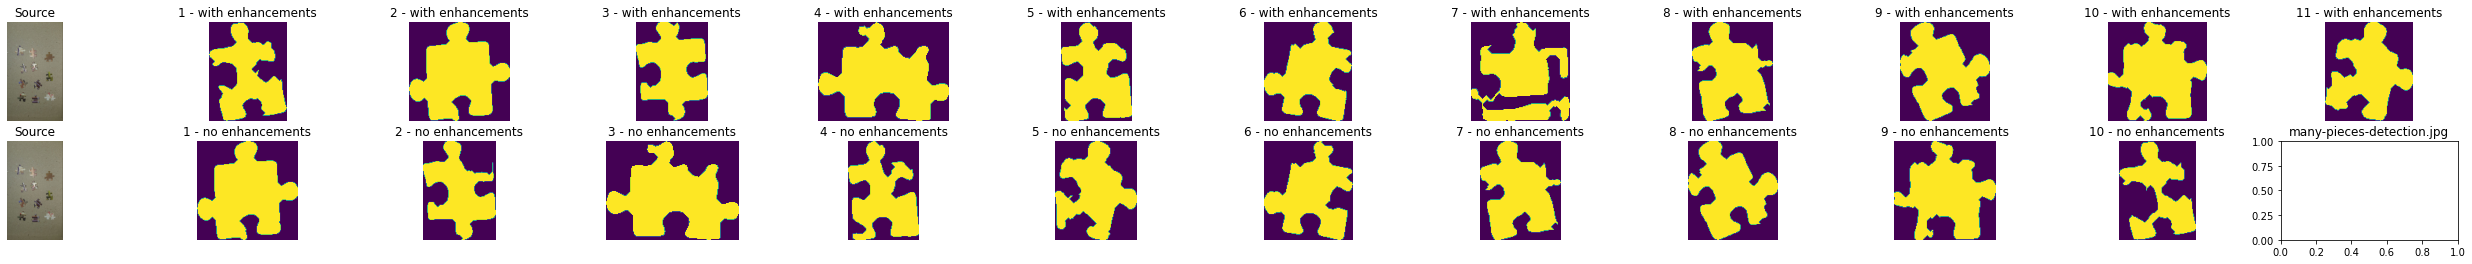

In [88]:
def enhancement_improvements(files: list):
    for file in files:
        img = imageio.imread(file)
        # with enhancents:
        pieces_pxs, pieces_img = img2piece(img, enhancements=enhancement_options)
        fig, axs = plt.subplots(2, len(pieces_img)+1, figsize=(4*len(pieces_img)+1, 4))
        ax = axs[0][0]
        ax.set_title("Source")
        ax.imshow(img)
        ax.axis("off")
        plt.title(file)
        for pxs_idx, pxs in enumerate(pieces_img):
            ax = axs[0][pxs_idx+1]
            ax.axis('off')
            ax.imshow(pxs)
            ax.set_title(f"{pxs_idx+1} - with enhancements")
        # without enhancements
        pieces_pxs, pieces_img = img2piece(img)
        ax = axs[1][0]
        ax.set_title("Source")
        ax.imshow(img)
        ax.axis("off")
        plt.title(file)
        for pxs_idx, pxs in enumerate(pieces_img):
            ax = axs[1][pxs_idx+1]
            ax.axis('off')
            ax.imshow(pxs)
            ax.set_title(f"{pxs_idx+1} - no enhancements")
        plt.show()

enhancement_improvements(test_images)

### Discussion and Limitations
The proposed method shows great results in piece identification and counting: it can reliably identify the bounding box of puzzle pieces and correctly count the number of pieces detected. Furthermore, in shape identification and clustering, the method shows acceptable results: the puzzle pieces are correctly clustered together. Moreover, this project demonstrated the usefulness of the techniques used, especially the morphological operators to modify and improve the highlights obtained by the edge detection technique. In particular, it proves that image enhancement techniques can increase the quality and robustness of image analysis models.

However, this project isn't without some limitations:
 - Edge-detection for piece detection: the method itself doesn't know whether it's looking at puzzle pieces or not, but rather, it's merely trying to identify edges that match two criteria of size and shape; still, we believe techniques employed combined with the provided criteria for pixel exclusion produces robust outputs.
 - Edge-detection on color-neutral backgrounds: the detection can produce bad results if the location in which the piece lies has patterns of its own. However, the testing images used are reasonable expectations as having a [color-neutral work surface to solve piece puzzles is a commonly used technique](https://www.amazon.com/Puzzle-Board/s?k=Puzzle+Board).
 - Parameters for edge-detection, filtering criteria, morphology methods: all techniques we used have parameters of their own which were optimized by trial-and-error. While the parameters we used are able to obtain good results in many cases, they are indeed sensitive to the quality and context of the input picture: a different distance from the pieces can affect the minimum pixel threshold on the second filtering criteria; the use of flash and lighting condition can affect the threshold parameters on the Canny Edge Detection.

### Conclusion

In this project, we set out the goal of building a puzzle piece detection, counting, and clustering application using commonly used image processing techniques as a final project. For this task, we decided to employ and analyze edge-detection techniques for this image segmentation task. By combining a set of morphology, search, measurement techniques, and a few hand-written exclusion criteria, we were able to correctly detect, count, and even cluster together pieces of similar shape. The method proved reliable in detecting and counting the pieces and showed acceptable results in image segmentation and shape clustering. As a future work, the model could be employed as a preprocessing step by a puzzle piece autosolver. 

The employment of edge-detection techniques for image segmentation was able to obtain great results. Still, the technique may fail to work properly when working on situations with too much scene variation is expected. Therefore, they are more appropriate for contexts where the scene and conditions to be analyzed are static, such as when using a fixed camera on a simple colorless background where only minor light changes are guaranteed.

## References
 - Canny, J., 1986. A computational approach to edge detection. IEEE Transactions on pattern analysis and machine intelligence, (6), pp.679-698.
 - Hu, M.K., 1962. Visual pattern recognition by moment invariants. IRE transactions on information theory, 8(2), pp.179-187.